In [1]:
%matplotlib widget

import os, glob, re
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

import xrayutilities as xu

import ipywidgets as ipw
from ipywidgets import interact

import fabio
from silx.io.specfile import SpecFile

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.widgets import RectangleSelector

## Functions

In [2]:
def get_single_image(fname, n, mask=None):
    imgs = fabio.open(fname)
    img = imgs.get_frame(n).data.astype(float)
    
    if mask is not None:
        img[mask == 1] = np.nan
        
    img[514:551, :] = np.nan
    img[0, 1029] = np.nan
        
    return img

## Paths

In [29]:
base_path = r'/msd_data/checkout/bl17-2/Aug2023_Li/NNO_STO'

scan_dir = 'cdw_mesh'

data_path = os.path.join(base_path, scan_dir)
img_path = os.path.join(data_path, 'images')

scan_dirs = ['cdw_mesh']
spec_fnames = {scan_dir:os.path.join(data_path, scan_dir) for scan_dir in scan_dirs}
img_h5s = {scan_dir:glob.glob(os.path.join(img_path, f'{scan_dir}*master.h5')) for scan_dir in scan_dirs}

img_files = glob.glob(os.path.join(img_path, f'{scan_dir}*master.h5'))
scans = {os.path.basename(img_file)[:-10]:img_file for img_file in img_files}

scans

{'cdw_mesh_scan003': '/msd_data/checkout/bl17-2/Aug2023_Li/NNO_STO/cdw_mesh/images/cdw_mesh_scan003_master.h5',
 'cdw_mesh_scan005': '/msd_data/checkout/bl17-2/Aug2023_Li/NNO_STO/cdw_mesh/images/cdw_mesh_scan005_master.h5',
 'cdw_mesh_scan004': '/msd_data/checkout/bl17-2/Aug2023_Li/NNO_STO/cdw_mesh/images/cdw_mesh_scan004_master.h5',
 'cdw_mesh_scan009': '/msd_data/checkout/bl17-2/Aug2023_Li/NNO_STO/cdw_mesh/images/cdw_mesh_scan009_master.h5',
 'cdw_mesh_scan015': '/msd_data/checkout/bl17-2/Aug2023_Li/NNO_STO/cdw_mesh/images/cdw_mesh_scan015_master.h5',
 'cdw_mesh_scan018': '/msd_data/checkout/bl17-2/Aug2023_Li/NNO_STO/cdw_mesh/images/cdw_mesh_scan018_master.h5',
 'cdw_mesh_scan019': '/msd_data/checkout/bl17-2/Aug2023_Li/NNO_STO/cdw_mesh/images/cdw_mesh_scan019_master.h5',
 'cdw_mesh_scan020': '/msd_data/checkout/bl17-2/Aug2023_Li/NNO_STO/cdw_mesh/images/cdw_mesh_scan020_master.h5'}

## Show raw images

interactive(children=(Dropdown(description='scan', index=7, options=('cdw_mesh_scan003', 'cdw_mesh_scan004', '…

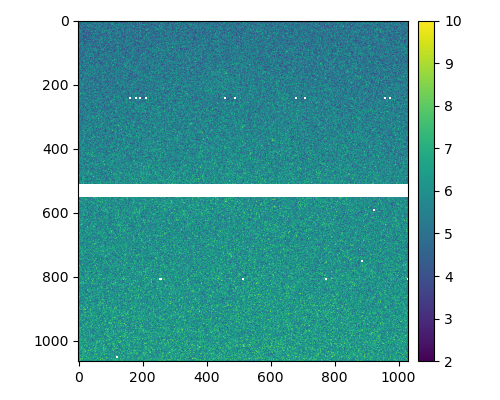

In [30]:
f1, f1_ax1 = plt.subplots(figsize=(5, 4), layout='tight')

divider = make_axes_locatable(f1_ax1)
f1_cax1 = divider.append_axes("right", size="5%", pad=0.1)
f1.add_axes(f1_cax1)

scan_widget = ipw.Dropdown(options=sorted(list(scans.keys())), value=list(scans.keys())[-1])
nimage_widget = ipw.IntSlider(min=0, max=1, step=1)
vminmax_widget = ipw.FloatRangeSlider(min=0, max=100, value=[5, 95], step=0.5)

@interact(
    scan=scan_widget,
    n=nimage_widget,
    vminmax=vminmax_widget
)
def show_raw_image(scan, n, vminmax):
    [ax.cla() for ax in f1.get_axes()]
    
    img_fname = scans[scan]
    ims = fabio.open(img_fname)
    nimage_widget.max = ims.nframes - 1
    
    im_arr = get_single_image(img_fname, n)
    im_arr[im_arr > 1e8] = np.nan
    
    minmax = np.nanpercentile(im_arr, vminmax)
    im = f1_ax1.imshow(im_arr, vmin=minmax[0], vmax=minmax[1])
    plt.colorbar(im, cax=f1_cax1)
    
    def onselect(eclick, erelease):
        print(eclick.xdata, eclick.ydata)
        print(erelease.xdata, erelease.ydata)
    
    props = dict(facecolor='blue', alpha=0.5)
    rect_selector = RectangleSelector(f1_ax1, onselect, props=props, interactive=True)
    rect_selector.add_state('square')

# Scan 005 TIFF image

interactive(children=(Dropdown(description='scan', index=1, options=('cdw_mesh_scan003', 'cdw_mesh_scan004', '…

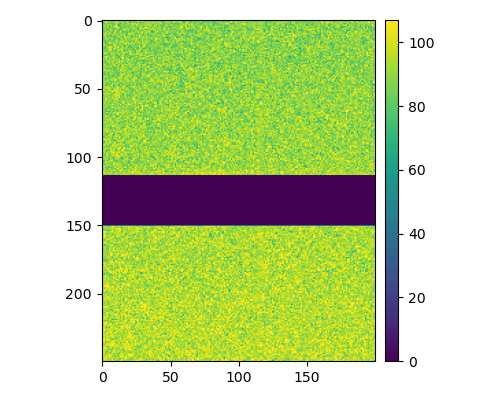

In [6]:
f1, f1_ax1 = plt.subplots(figsize=(5, 4), layout='tight')

divider = make_axes_locatable(f1_ax1)
f1_cax1 = divider.append_axes("right", size="5%", pad=0.1)
f1.add_axes(f1_cax1)

scan_widget = ipw.Dropdown(options=sorted(list(scans.keys())), value=list(scans.keys())[-1])
nimage_widget = ipw.IntSlider(min=0, max=1, step=1)
vminmax_widget = ipw.FloatRangeSlider(min=0, max=100, value=[5, 95], step=0.5)

@interact(
    scan=scan_widget,
    n=nimage_widget,
    vminmax=vminmax_widget
)
def show_raw_image(scan, n, vminmax):
    [ax.cla() for ax in f1.get_axes()]
    scan_num = int(scan[-3:])
    sf = SpecFile(spec_fnames[scan_dir])[scan_num-1]
    
    nimage_widget.max = np.shape(sf.data)[1]-1
    
    img_fname = scans[scan]
    img = fabio.open(scans[scan][:-10]+'/'+scan+'_'+str(n).zfill(4)+'.tif').data

    img = img[400:650,400:600]
    minmax = np.nanpercentile(img, vminmax)
    im = f1_ax1.imshow(img, vmin=minmax[0], vmax=minmax[1])
    plt.colorbar(im, cax=f1_cax1)
    
    
    for line in sf.header:
        if line[:3] == '#G3':
            UB = np.array(line.split(' ')[-9:]).astype(float).reshape([3,3])
        if line[:3] == '#P0':
            angles = np.array(line.split(' ')[1:-2]).astype(float)
    
    try:
        tt = sf.data_column_by_name('del')
    except:
        tt = angles[0] * np.ones(np.shape(sf.data)[1])

    try:
        eta = sf.data_column_by_name('eta')
    except:
        eta = angles[1] * np.ones(np.shape(sf.data)[1])

    try:
        chi = sf.data_column_by_name('chi')-90
    except:
        chi = angles[2] * np.ones(np.shape(sf.data)[1])-90

    try:
        phi = sf.data_column_by_name('phi')
    except:
        phi = angles[3] * np.ones(np.shape(sf.data)[1])
    
#     def onselect(eclick, erelease):
#         print(eclick.xdata, eclick.ydata)
#         print(erelease.xdata, erelease.ydata)
    
#     props = dict(facecolor='blue', alpha=0.5)
#     rect_selector = RectangleSelector(f1_ax1, onselect, props=props, interactive=True)
#     rect_selector.add_state('square')

## Mapping CCD pixel to HKL

In [90]:
scan_num = 5
sf = SpecFile(spec_fnames['cdw_mesh'])
scan = sf[scan_num-1]
print('scan number: ' + str(scan.number) + ', length: ' + str(np.shape(scan.data)[1]))
# UB = np.array(scan.header[5].split(' ')[-9:]).astype(float).reshape([3,3])
# angles = np.array(scan.header[8].split(' ')[1:-2]).astype(float)

for line in scan.header:
    if line[:3] == '#G3':
        UB = np.array(line.split(' ')[-9:]).astype(float).reshape([3,3])
    if line[:3] == '#P0':
        angles = np.array(line.split(' ')[1:-2]).astype(float)

try:
    tt = scan.data_column_by_name('del')
except:
    tt = angles[0] * np.ones(np.shape(scan.data)[1])
    
try:
    eta = scan.data_column_by_name('eta')
except:
    eta = angles[1] * np.ones(np.shape(scan.data)[1])

try:
    chi = scan.data_column_by_name('chi')-90
except:
    chi = angles[2] * np.ones(np.shape(scan.data)[1])-90
    
try:
    phi = scan.data_column_by_name('phi')
except:
    phi = angles[3] * np.ones(np.shape(scan.data)[1])

scan number: 5, length: 7703


In [91]:
qconversion = xu.QConversion(sampleAxis = ['x+','y-','x+'], detectorAxis = ['x+'], r_i = [0,1,0], en = 8333)

hxrd = xu.HXRD( [1,0,0], [0,0,1], qconv =  qconversion)

hxrd.Ang2Q.init_area(
        'z+', 'x-',
        cch1=532, cch2=515,
        Nch1=1065, Nch2=1030,
        pwidth1=0.075, pwidth2=0.075,
        distance=540
    )

In [79]:
# angle_values =   [eta, chi, phi, tt]   #[[26.056],  [13.028]]
# qx, qy, qz = hxrd.Ang2Q.area(*angle_values, UB=UB)

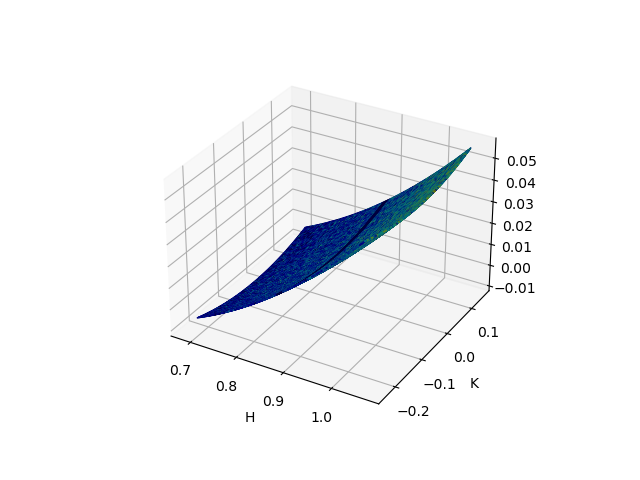

In [92]:
idx = 6

angle_values =   [eta[idx], chi[idx], phi[idx], tt[idx]]   #[[26.056],  [13.028]]
qx, qy, qz = hxrd.Ang2Q.area(*angle_values, UB=UB)
# plt.figure()
# plt.subplot(131)
# plt.imshow(qx[idx])
# plt.title('qx')

# plt.subplot(132)
# plt.imshow(qy[idx])
# plt.title('qy')

# plt.subplot(133)
# plt.imshow(qz[idx])
# plt.title('qz')

# img = np.nan_to_num(get_single_image(scans[scan_dir+'_scan'+str(scan_num).zfill(3)], idx))
img = fabio.open(scans[scan_dir+'_scan'+str(scan_num).zfill(3)][:-10]+'/'+scan_dir+'_scan'+str(scan_num).zfill(3)+'_'+str(idx).zfill(4)+'.tif').data
minmax = np.nanpercentile(img, [5, 95])
img = (img-minmax[0])/minmax[1]
c = cm.jet(img)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(qx,qy,qz, facecolors = c,
               # antialiased = True,
        rstride=10, cstride=10, alpha=None)
plt.xlabel('H')
plt.ylabel('K')
# plt.zlabel('L')

plt.show()

interactive(children=(IntSlider(value=0, description='n', max=7702), FloatRangeSlider(value=(5.0, 95.0), descr…

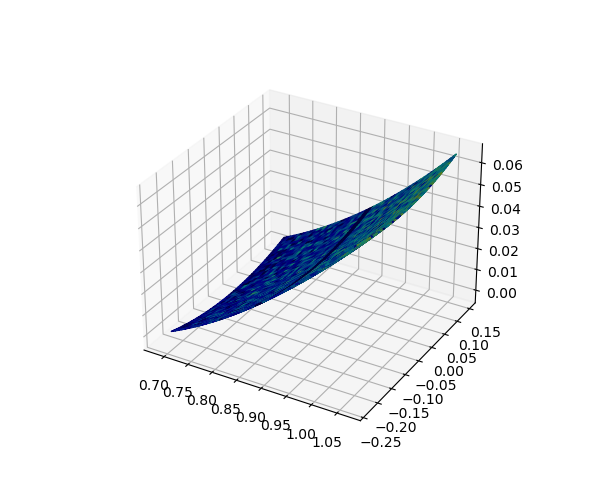

In [99]:
f1, f1_ax1 = plt.subplots(figsize=(6, 5), subplot_kw={"projection": "3d"})

# divider = make_axes_locatable(f1_ax1)
# f1_cax1 = divider.append_axes("right", size="5%", pad=0.1)
# f1.add_axes(f1_cax1)

nimage_widget = ipw.IntSlider(min=0, max=np.shape(scan.data)[1]-1, step=1)
vminmax_widget = ipw.FloatRangeSlider(min=0, max=100, value=[5, 95], step=0.5)

@interact(
    n=nimage_widget,
    vminmax=vminmax_widget
)
def show_raw_image(n, vminmax):
    [ax.cla() for ax in f1.get_axes()]
    
    angle_values =   [eta[n], chi[n], phi[n], tt[n]]   #[[26.056],  [13.028]]
    qx, qy, qz = hxrd.Ang2Q.area(*angle_values, UB=UB)
    
    # img = np.nan_to_num(get_single_image(scans[scan_dir+'_scan'+str(scan_num).zfill(3)], n))
    img = fabio.open(scans[scan_dir+'_scan'+str(scan_num).zfill(3)][:-10]+'/'+scan_dir+'_scan'+str(scan_num).zfill(3)+'_'+str(idx).zfill(4)+'.tif').data

    minmax = np.nanpercentile(img, vminmax)
    img = (img-minmax[0])/minmax[1]
    c = cm.jet(img)

    f1_ax1.plot_surface(qx,qy,qz, facecolors = c)

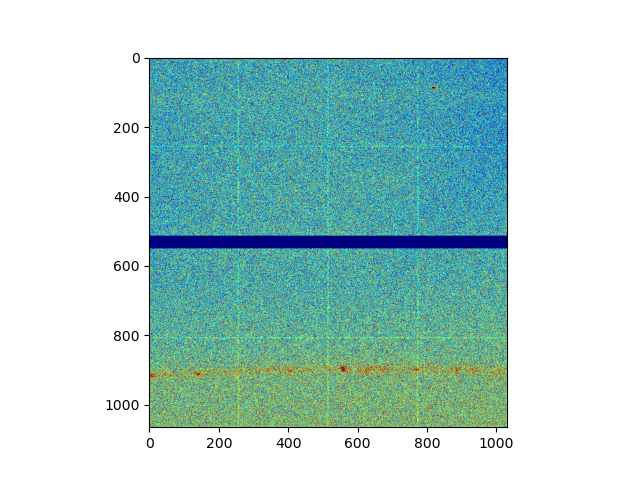

In [23]:
plt.figure()
plt.imshow(c)
plt.show()

## integrating the CCD to get intensity

In [7]:
scan = 'cdw_mesh_scan005'
scan_num = int(scan[-3:])
sf = SpecFile(spec_fnames[scan_dir])[scan_num-1]
img_fname = scans[scan]


H=sf.data_column_by_name('H')
K=sf.data_column_by_name('K')
L=sf.data_column_by_name('L')
intensity = np.zeros_like(H)

for n in np.arange(np.shape(sf.data)[1]-1):
    print(n)
    try:
        img = fabio.open(scans[scan][:-10]+'/'+scan+'_'+str(n).zfill(4)+'.tif').data[400:650,400:600]
        intensity[n] = np.nanmean(img)
    except:
        intensity[n] = intensity[n-1]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

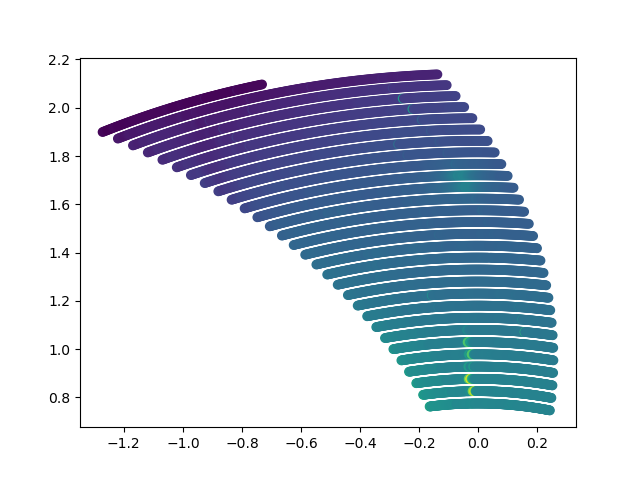

In [15]:
# intensity[intensity > 1e3] = np.nan

# plt.figure()
# plt.plot(K, intensity)
# plt.show()


plt.figure()
plt.scatter(K, L, c = np.log(intensity))
plt.show()

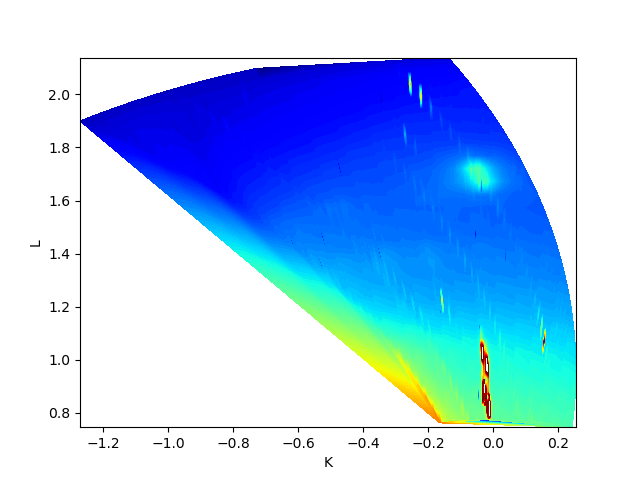

In [33]:
I = intensity
I = np.nan_to_num(I)
plt.figure()
plt.tricontourf(K,L,I, levels=np.linspace(0,100,100), cmap="jet")
plt.xlabel('K')
plt.ylabel('L')
plt.show()

# Scan 009

interactive(children=(Dropdown(description='scan', index=3, options=('cdw_mesh_scan003', 'cdw_mesh_scan004', '…

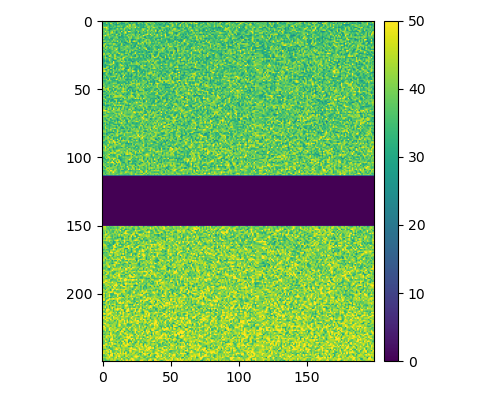

In [9]:
f1, f1_ax1 = plt.subplots(figsize=(5, 4), layout='tight')

divider = make_axes_locatable(f1_ax1)
f1_cax1 = divider.append_axes("right", size="5%", pad=0.1)
f1.add_axes(f1_cax1)

scan_widget = ipw.Dropdown(options=sorted(list(scans.keys())), value=list(scans.keys())[-1])
nimage_widget = ipw.IntSlider(min=0, max=1, step=1)
vminmax_widget = ipw.FloatRangeSlider(min=0, max=100, value=[5, 95], step=0.5)

@interact(
    scan=scan_widget,
    n=nimage_widget,
    vminmax=vminmax_widget
)
def show_raw_image(scan, n, vminmax):
    [ax.cla() for ax in f1.get_axes()]
    scan_num = int(scan[-3:])
    sf = SpecFile(spec_fnames[scan_dir])[scan_num-1]
    
    nimage_widget.max = np.shape(sf.data)[1]-1
    
    img_fname = scans[scan]
    img = fabio.open(scans[scan][:-10]+'/'+scan+'_'+str(n).zfill(4)+'.tif').data

    img = img[400:650,400:600]
    minmax = np.nanpercentile(img, vminmax)
    im = f1_ax1.imshow(img, vmin=minmax[0], vmax=minmax[1])
    plt.colorbar(im, cax=f1_cax1)
    
    
    for line in sf.header:
        if line[:3] == '#G3':
            UB = np.array(line.split(' ')[-9:]).astype(float).reshape([3,3])
        if line[:3] == '#P0':
            angles = np.array(line.split(' ')[1:-2]).astype(float)
    
    try:
        tt = sf.data_column_by_name('del')
    except:
        tt = angles[0] * np.ones(np.shape(sf.data)[1])

    try:
        eta = sf.data_column_by_name('eta')
    except:
        eta = angles[1] * np.ones(np.shape(sf.data)[1])

    try:
        chi = sf.data_column_by_name('chi')-90
    except:
        chi = angles[2] * np.ones(np.shape(sf.data)[1])-90

    try:
        phi = sf.data_column_by_name('phi')
    except:
        phi = angles[3] * np.ones(np.shape(sf.data)[1])
    

In [11]:
scan_length = 1564

In [10]:
scan = 'cdw_mesh_scan009'
scan_num = int(scan[-3:])
sf = SpecFile(spec_fnames[scan_dir])[scan_num-1]
img_fname = scans[scan]


H=sf.data_column_by_name('H')[:scan_length]
K=sf.data_column_by_name('K')[:scan_length]
L=sf.data_column_by_name('L')[:scan_length]
intensity = np.zeros_like(H)

scan_length = 1564

for n in np.arange(scan_length):
    print(n)
    try:
        img = fabio.open(scans[scan][:-10]+'/'+scan+'_'+str(n).zfill(4)+'.tif').data[400:650,400:600]
        intensity[n] = np.nanmean(img)
    except:
        intensity[n] = intensity[n-1]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

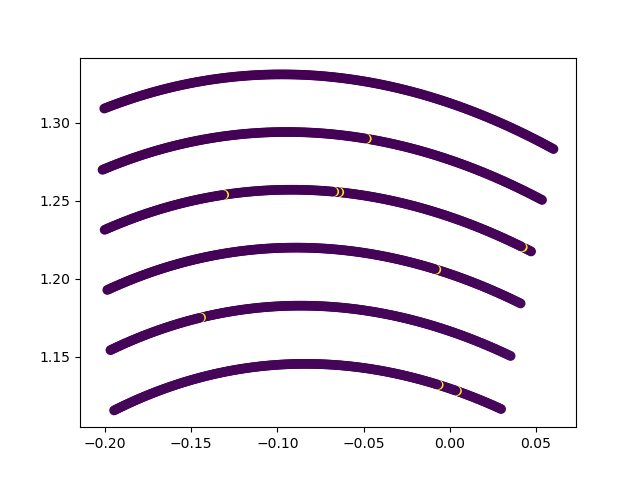

In [15]:
plt.figure()
plt.scatter(K, L, c = np.log(intensity[:scan_length]))
plt.show()

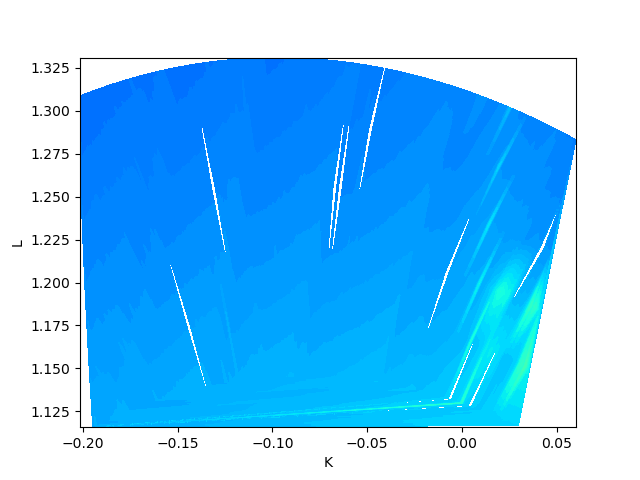

In [16]:
I = intensity
I = np.nan_to_num(I)
plt.figure()
plt.tricontourf(K,L,I[:scan_length], levels=np.linspace(0,100,100), cmap="jet")
plt.xlabel('K')
plt.ylabel('L')
plt.show()

### Get ROI extents

In [ ]:
f1, f1_ax1 = plt.subplots(figsize=(6, 5), layout="constrained")

divider = make_axes_locatable(f1_ax1)
f1_cax1 = divider.append_axes("right", size="5%", pad=0.1)
f1.add_axes(f1_cax1)

#ims = fabio.open(scans[scan])

im_arr = get_single_image(scans[list(scans.keys())[-1]], 0)
im_arr[im_arr > 1e8] = np.nan
   
minmax = np.nanpercentile(im_arr, [5, 95])
im = f1_ax1.imshow(im_arr, vmin=minmax[0], vmax=minmax[1])
plt.colorbar(im, cax=f1_cax1)
    
def onselect(eclick, erelease):
    global extent

    x1, y1 = eclick.xdata, eclick.ydata
    x2, y2 = erelease.xdata, erelease.ydata
    
    extent = [int(x.round()) for x in [x1, y1, x2, y2]]
    
    print(eclick.xdata, eclick.ydata)
    print(erelease.xdata, erelease.ydata)
    
props = dict(facecolor='blue', alpha=0.5)
rect_selector = RectangleSelector(f1_ax1, onselect, 
                                  useblit=True,
                                  button=[1, 3],  # disable middle button
                                  minspanx=5, minspany=5,
                                  spancoords='pixels',
                                  props=props, interactive=True)
rect_selector.add_state('square')

In [ ]:
1+1

### Show ROI sum

In [24]:
print(command)
a = re.search(r"\s", command)
a.group(1)

ascan  energy 8328 8338  10 1


IndexError: no such group

In [21]:
spec_file = SpecFile(spec_fnames[scan_dir])
command = spec_file.command(18)
#motor = 

interactive(children=(Dropdown(description='scan', index=25, options=('find_ubr_scan003', 'find_ubr_scan002', …

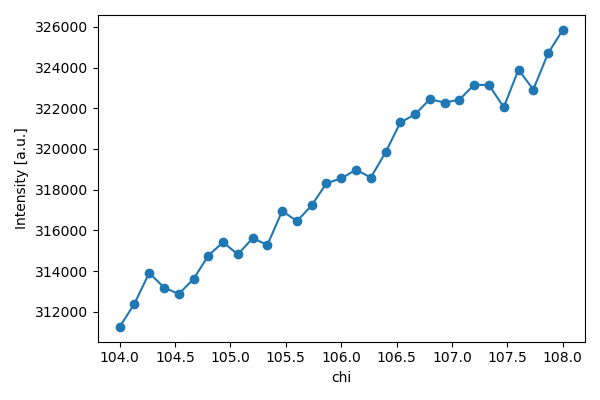

In [27]:
f2, f2_ax1 = plt.subplots(figsize=(6, 4), layout='tight')

scan_widget = ipw.Dropdown(options=list(scans.keys()), value=list(scans.keys())[-1])

@interact(
    scan=scan_widget,
)
def show_ROI_sum(scan):
    [ax.cla() for ax in f2.get_axes()]

    spec_scan_number = int(scan[-3:]) - 1
    print(spec_scan_number)
    spec_file = SpecFile(spec_fnames[scan_dir])
    spec_scan = spec_file[spec_scan_number]

    x_col = 'chi'
    x_data = spec_scan.data_column_by_name(x_col)

    img_fname = scans[scan]
    ims = fabio.open(img_fname)
    
    roi_sum = []
    for im in ims:
        im_arr = im.data.astype(float)
        im_arr[im_arr > 1e8] = np.nan
        # img = imgs.get_frame(n).data
        im_arr[514:551, :] = np.nan
        im_arr[0, 1029] = np.nan
    
        im_roi = im_arr[extent[1]:extent[3], extent[0]:extent[2]]
        roi_sum.append(np.nansum(im_roi))
        
    
    f2_ax1.plot(x_data, roi_sum, 'o-')
    f2_ax1.set_xlabel(x_col)
    f2_ax1.set_ylabel('Intensity [a.u.]')

In [35]:
spec_fnames

{'find_ubr': '/msd_data/checkout/bl17-2/Aug2023_Li/NNO_STO/find_ubr/find_ubr'}

In [37]:
spec_scan = spec_file[2]

In [38]:
x_data = spec_scan.data_column_by_name('eta')

In [42]:
img_files = img_h5s[sc]

img_fnames = [os.path.basename(img_file) for img_file in img_files]

## Show raw images

interactive(children=(Dropdown(description='scan', options=('find_ubr_scan003_master.h5', 'find_ubr_scan002_ma…

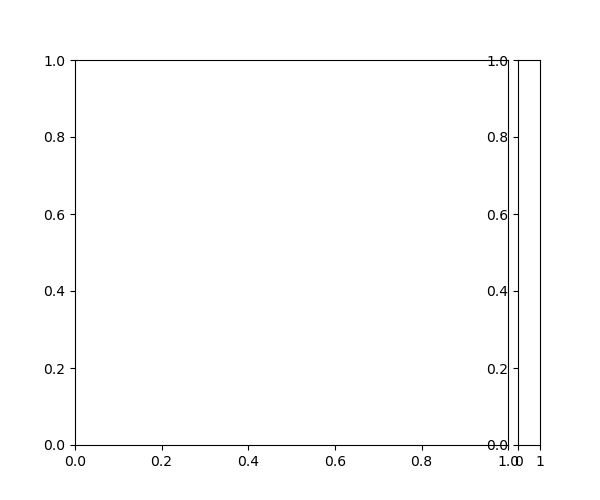

In [43]:
f1, f1_ax1 = plt.subplots(figsize=(6, 5))

divider = make_axes_locatable(f1_ax1)
f1_cax1 = divider.append_axes("right", size="5%", pad=0.1)
f1.add_axes(f1_cax1)

scan_widget = ipw.Dropdown(options=img_fnames)
nimage_widget = ipw.IntSlider(min=0, max=1, step=1)
vminmax_widget = ipw.FloatRangeSlider(min=0, max=100, value=[5, 95], step=0.5)

@interact(
    scan=scan_widget,
    n=nimage_widget,
    vminmax=vminmax_widget
)
def show_raw_image(scan, n, vminmax):
    [ax.cla() for ax in f1.get_axes()]
    
    ims = fabio.open(scan)
    nimage_widget.max = ims.nframes - 1
    
    im_arr = get_single_image(scan, n)
    im_arr[im_arr > 1e8] = np.nan
    
    minmax = np.nanpercentile(im_arr, vminmax)
    im = f1_ax1.imshow(im_arr, vmin=minmax[0], vmax=minmax[1])
    plt.colorbar(im, cax=f1_cax1)
    
    def onselect(eclick, erelease):
        print(eclick.xdata, eclick.ydata)
        print(erelease.xdata, erelease.ydata)
    
    props = dict(facecolor='blue', alpha=0.5)
    rect_selector = RectangleSelector(f1_ax1, onselect, props=props, interactive=True)
    rect_selector.add_state('square')

## Show ROI Sums

### Get ROI extents

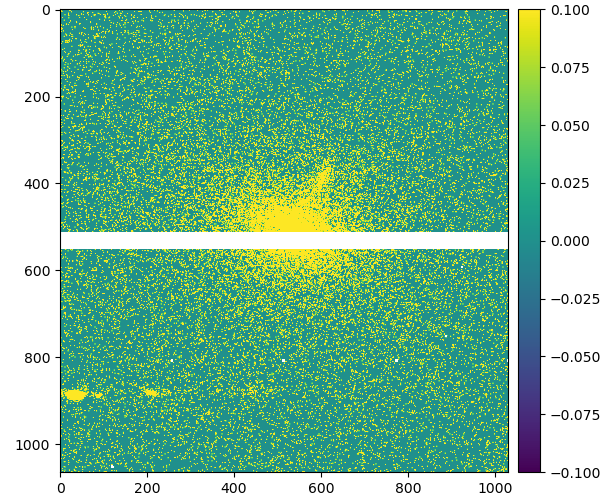

In [22]:
f1, f1_ax1 = plt.subplots(figsize=(6, 5), layout="constrained")

divider = make_axes_locatable(f1_ax1)
f1_cax1 = divider.append_axes("right", size="5%", pad=0.1)
f1.add_axes(f1_cax1)

ims = fabio.open(scans[0])

im_arr = get_single_image(scans[0], 0)
im_arr[im_arr > 1e8] = np.nan
   
minmax = np.nanpercentile(im_arr, [5, 95])
im = f1_ax1.imshow(im_arr, vmin=minmax[0], vmax=minmax[1])
plt.colorbar(im, cax=f1_cax1)
    
def onselect(eclick, erelease):
    global extent

    x1, y1 = eclick.xdata, eclick.ydata
    x2, y2 = erelease.xdata, erelease.ydata
    
    extent = [int(x.round()) for x in [x1, y1, x2, y2]]
    
    print(eclick.xdata, eclick.ydata)
    print(erelease.xdata, erelease.ydata)
    
    
props = dict(facecolor='blue', alpha=0.5)
rect_selector = RectangleSelector(f1_ax1, onselect, props=props, interactive=True)
rect_selector.add_state('square')

### Show ROI sum

In [36]:
extent

[536, 241, 758, 463]

interactive(children=(Dropdown(description='scan', options=('/msd_data/checkout/bl17-2/det_psic_test/images/rm…

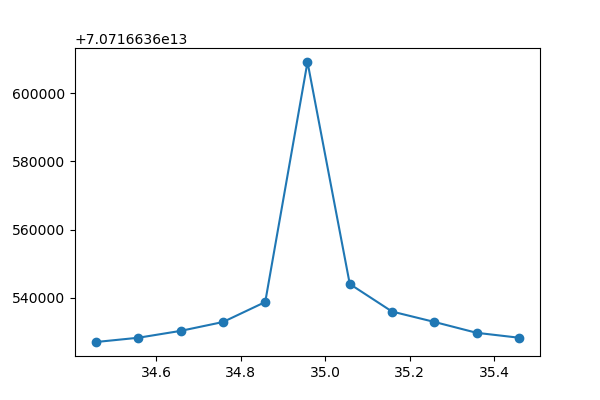

In [24]:
f2, f2_ax1 = plt.subplots(figsize=(6, 4))

scan_widget = ipw.Dropdown(options=scans)

@interact(
    scan=scan_widget,
)
def show_ROI_sum(scan):
    [ax.cla() for ax in f2.get_axes()]
    
    ims = fabio.open(scan)

    roi_sum = []
    for im in ims:
        im_arr = im.data
        im_roi = im_arr[extent[1]:extent[3], extent[0]:extent[2]]
        roi_sum.append(np.nansum(im_roi))
        
    
    f2_ax1.plot(x_data, roi_sum, 'o-')
    f2_ax1

In [25]:
int((extent[0]-0.4).round())

324

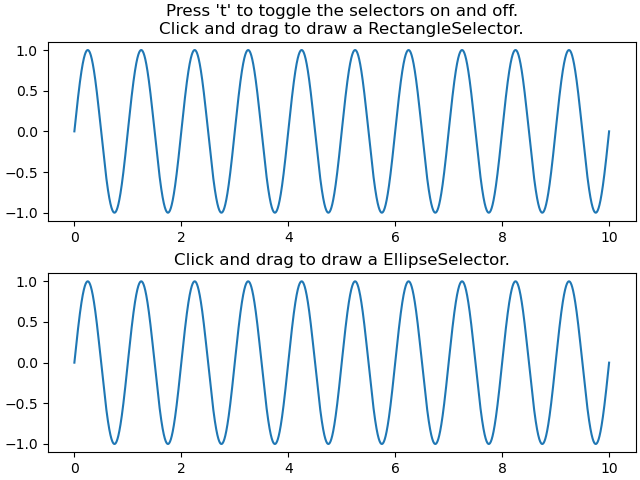

In [6]:
from matplotlib.widgets import EllipseSelector, RectangleSelector
import numpy as np
import matplotlib.pyplot as plt


def select_callback(eclick, erelease):
    """
    Callback for line selection.

    *eclick* and *erelease* are the press and release events.
    """
    global extent
    
    x1, y1 = eclick.xdata, eclick.ydata
    x2, y2 = erelease.xdata, erelease.ydata
    
    extent = [x1, y1, x2, y2
             ]
    print(f"({x1:3.2f}, {y1:3.2f}) --> ({x2:3.2f}, {y2:3.2f})")
    print(f"The buttons you used were: {eclick.button} {erelease.button}")
    

def toggle_selector(event):
    print('Key pressed.')
    if event.key == 't':
        for selector in selectors:
            name = type(selector).__name__
            if selector.active:
                print(f'{name} deactivated.')
                selector.set_active(False)
            else:
                print(f'{name} activated.')
                selector.set_active(True)


fig = plt.figure(layout='constrained')
axs = fig.subplots(2)

N = 100000  # If N is large one can see improvement by using blitting.
x = np.linspace(0, 10, N)

selectors = []
for ax, selector_class in zip(axs, [RectangleSelector, EllipseSelector]):
    ax.plot(x, np.sin(2*np.pi*x))  # plot something
    ax.set_title(f"Click and drag to draw a {selector_class.__name__}.")
    selectors.append(selector_class(
        ax, select_callback,
        useblit=True,
        button=[1, 3],  # disable middle button
        minspanx=5, minspany=5,
        spancoords='pixels',
        interactive=True))
    fig.canvas.mpl_connect('key_press_event', toggle_selector)
axs[0].set_title("Press 't' to toggle the selectors on and off.\n"
                 + axs[0].get_title())
plt.show()

In [8]:
extent

[3.8282941186148296,
 -0.5092067238051216,
 5.959990897119711,
 0.4896137238032865]